In [1]:
import os
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics

from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import (
    Layer, Multiply,GlobalAveragePooling1D,MultiHeadAttention,Embedding,Lambda,Dense,Flatten,Conv2D,Dropout, Conv2DTranspose, MaxPooling2D, Input, Activation,
    Concatenate, UpSampling2D, Resizing,Reshape,Add,LayerNormalization,BatchNormalization
)
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.initializers import TruncatedNormal
from einops import rearrange
import pickle
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
import albumentations as A
import time

In [2]:
path = '/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset'

In [3]:
data = tf.keras.utils.image_dataset_from_directory(directory = path, image_size = (128, 128), batch_size = 6000, shuffle = False)

Found 5682 files belonging to 2 classes.


In [4]:
for images, masks in data:
    X = images.numpy().astype("uint8")
    y = masks.numpy().astype("uint8")

print(X.shape, y.shape)

(5682, 128, 128, 3) (5682,)


In [5]:
images = X[y == 0]
masks = X[y == 1]

print(images.shape, masks.shape)

(2841, 128, 128, 3) (2841, 128, 128, 3)


In [6]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(images, masks, test_size = 0.2, random_state = 3)

print(X_train.shape, X_test.shape)

(2272, 128, 128, 3) (569, 128, 128, 3)


In [7]:
# Convert masks to single channel (binary)
y_train = (y_train[..., 0] > 0).astype("uint8")  # Assuming the first channel represents the mask
y_test = (y_test[..., 0] > 0).astype("uint8")
print(y_train.shape, y_test.shape)
# Reshape your target arrays to match the model's output shape
y_train = y_train.reshape((-1, 128, 128, 1))
y_test = y_test.reshape((-1, 128, 128, 1))

print(y_train.shape, y_test.shape)

(2272, 128, 128) (569, 128, 128)
(2272, 128, 128, 1) (569, 128, 128, 1)


In [8]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ElasticTransform(p=0.2),
    A.GridDistortion(p=0.2),
])

def augment_image(img, mask):
    augmented = transform(image=img, mask=mask)
    return augmented['image'], augmented['mask']

X_aug, y_aug = zip(*[augment_image(img, mask) for img, mask in zip(X_train, y_train)])

X_train = np.concatenate((X_train, np.array(X_aug)), axis=0)
y_train = np.concatenate((y_train, np.array(y_aug)), axis=0)

In [9]:
print(f"X_train: {X_train.shape} and y_train: {y_train.shape}")

X_train: (4544, 128, 128, 3) and y_train: (4544, 128, 128, 1)


In [10]:
def plot_images(X_test, y_test, model_mask, selected_indices):
    for i in selected_indices:
        plt.figure(figsize=(15,5))

        # orignal image
        plt.subplot(1,4,1)
        plt.imshow(X_test[i].squeeze())
        plt.title("Orignal Image")
        plt.axis("off")

        # Orignal Mask
        plt.subplot(1,4,2)
        plt.imshow(y_test[i].squeeze(), cmap='viridis')
        plt.title('Orignal Mask')
        plt.axis("off")

        # Model Mask
        plt.subplot(1,4,3)
        plt.imshow(model_mask[i].squeeze(), cmap='viridis')
        plt.title('Model Mask')
        plt.axis("off")
    plt.show()

In [11]:
def plot_training_history(history, title):
    # Check if `history` is a dictionary and adapt
    if isinstance(history, dict):
        acc = history['accuracy']
        val_acc = history['val_accuracy']
        loss = history['loss']
        val_loss = history['val_loss']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

    # Plot Accuracy
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt

In [12]:
def Testing_IoU(model, X_test, y_test): # Added y_test as an argument
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)
    y_true_flat = y_test.flatten()
    y_pred_flat = y_pred.flatten()
    y_true_flat = (y_true_flat > 0.5).astype(int)
    testing_iou = jaccard_score(y_true_flat, y_pred_flat, average='macro')
    return testing_iou

def Training_IoU(model, X_train, y_train): # Added y_train as an argument
    y_pred_prob = model.predict(X_train)
    y_pred = (y_pred_prob > 0.5).astype(int)
    y_true_flat = y_train.flatten()  # Changed y_test to y_train
    y_pred_flat = y_pred.flatten()
    y_true_flat = (y_true_flat > 0.5).astype(int)
    training_iou = jaccard_score(y_true_flat, y_pred_flat, average='macro')
    return training_iou

In [13]:
def calculate_IOU_per_image(y_true, y_pred, threshold=0.5):
    # Binarize predictions for each image
    iou_list = []
    for i in range(y_true.shape[0]):
        y_true_img = (y_true[i] > threshold).astype(int).flatten()
        y_pred_img = (y_pred[i] > threshold).astype(int).flatten()
        iou = jaccard_score(y_true_img, y_pred_img)
        iou_list.append(iou)
    return np.mean(iou_list)

def Testing_IoU(model, X_test, y_test):
    y_pred_prob = model.predict(X_test)
    return calculate_IOU_per_image(y_test, y_pred_prob)

def Training_IoU(model, X_train, y_train):
    y_pred_prob = model.predict(X_train)
    return calculate_IOU_per_image(y_train, y_pred_prob)


In [14]:
def Testing_F1(model, X_test, y_test):
    # Predict probabilities
    y_pred_prob = model.predict(X_test)
    # Threshold predictions to get binary masks
    y_pred = (y_pred_prob > 0.5).astype(int)
    # Flatten the arrays
    y_true_flat = y_test.flatten()
    y_pred_flat = y_pred.flatten()
    # Ensure binary ground truth
    y_true_flat = (y_true_flat > 0.5).astype(int)
    return f1_score(y_true_flat, y_pred_flat)

def Training_F1(model, X_train, y_train):
    y_pred_prob = model.predict(X_train)
    y_pred = (y_pred_prob > 0.5).astype(int)
    y_true_flat = y_train.flatten()
    y_pred_flat = y_pred.flatten()
    y_true_flat = (y_true_flat > 0.5).astype(int)
    return f1_score(y_true_flat, y_pred_flat)


In [15]:
def evaluation(model, model_name):
    #results_train = model.evaluate(X_train, y_train, verbose=0)
    #results_test = model.evaluate(X_test, y_test, verbose=0)

    #train_loss, train_accuracy = results_train[0], results_train[1]
    #test_loss, test_accuracy = results_test[0], results_test[1]

    train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

    data = {
    'Algorithm': [model_name[0], model_name[1]],
    'Accuracy': [f"{train_accuracy:.3f}", f"{test_accuracy:.3f}"],
    'Loss': [f"{train_loss:.3f}", f"{test_loss:.3f}"],
    'mIOU': [f"{Training_IoU(model, X_train, y_train):.3f}", f"{Testing_IoU(model, X_test, y_test):.3f}"],
    'F1 Score': [f"{Training_F1(model, X_train, y_train):.3f}", f"{Testing_F1(model, X_test, y_test):.3f}"]
    }

    df = pd.DataFrame(data)

    return df

In [16]:
config = {}
config["image_size"] = 128
config["num_channels"] = 3
config["num_layers"] = 12
config["hidden_dim"] = 512
config["mlp_dim"] = 3072
config["num_heads"] = 12
config["dropout_rate"] = 0.1
#config["num_patches"] = 256
config["patch_size"] = 16
config["num_patches"] = (config["image_size"]**2) // (config["patch_size"]**2)
print(config["num_patches"])

64


In [17]:
@keras.saving.register_keras_serializable()
class Create_Patches(Layer):
    def __init__(self, patch_size, channels=3, **kwargs):
        super(Create_Patches, self).__init__(**kwargs)
        self.patch_size = patch_size
        self.channels = channels
        # Use a Conv2D layer with filters = window_size * window_size * channels
        self.conv = Conv2D(
            filters=patch_size * patch_size * channels,  # Number of patch features
            kernel_size=patch_size,
            strides=patch_size,
            padding="valid",
        )

    def call(self, images):
        # Apply convolution to extract patches
        patches = self.conv(images)
        shape = tf.shape(patches)
        B, H, W, C = shape[0], shape[1], shape[2], shape[3]
        #B, H, W, C = tf.shape(patches)
        # Reshape to [B, H*W, C] where C = window_size * window_size * channels
        patches = tf.reshape(patches, [B, H * W, C])
        return patches

    def compute_output_shape(self, input_shape):
        B, H, W, C = input_shape
        # Calculate new height and width after convolution
        new_H = H // self.patch_size
        new_W = W // self.patch_size
        # Output shape is [B, new_H * new_W, window_size * window_size * channels]
        return (B, new_H * new_W, self.patch_size * self.patch_size * self.channels)

In [ ]:
#X_train = tf.cast(X_train, tf.float32)
batch = tf.cast(X_train, tf.float32)
patches = Create_Patches(config["patch_size"])(batch[:32])
patches.shape

In [ ]:
plt.figure(figsize=(5, 5))
plt.imshow(X_train[0].astype("uint8"))
plt.title("Original Image", fontsize=16)
plt.axis("off")
plt.show()

In [ ]:
n = int(np.sqrt(patches.shape[1]))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (config["patch_size"], config["patch_size"], 3))
    ax.imshow(patch_img.numpy().astype("uint8"))
    ax.axis("off")

In [18]:
@keras.saving.register_keras_serializable()
class LinearEmbedding(Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super(LinearEmbedding, self).__init__(**kwargs)
        self.num_patches = num_patches
        self.projection = Dense(projection_dim)
        self.position_embedding = Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patch):
        # calculate patches embeddings
        patches_embed = self.projection(patch)
        # calcualte positional embeddings
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        positions_embed = self.position_embedding(positions)
        # add both embeddings
        encoded = patches_embed + positions_embed
        return encoded

In [ ]:
data = (patches.shape[1], patches.shape[2])
print(data)
embeddings = LinearEmbedding(config["num_patches"], config["hidden_dim"])(patches[:32])
embeddings.shape

In [19]:
@keras.saving.register_keras_serializable()
class MLP(Layer):
    def __init__(self, mlp_dim, hidden_dim, dropout_rate=0.1, **kwargs):
        super(MLP, self).__init__(**kwargs)
        self.dense1 = Dense(mlp_dim, activation=tf.nn.gelu)
        self.dense2 = Dense(hidden_dim)
        self.dropout = Dropout(dropout_rate)

    def call(self, x):
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        y = self.dropout(x)
        return y

In [ ]:
mlp = MLP(config["mlp_dim"],config["hidden_dim"])(patches[:32])
mlp.shape

In [20]:
@keras.saving.register_keras_serializable()
class TransformerEncoder(Layer):
    def __init__(self, num_heads, hidden_dim, mlp_dim, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim
        self.mlp_dim = mlp_dim

        self.layer_norm1 = LayerNormalization()
        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=hidden_dim)
        self.add1 = Add()

        self.layer_norm2 = LayerNormalization()
        self.mlp = MLP(config["mlp_dim"],config["hidden_dim"])
        self.add2 = Add()

    def call(self, inputs):
        # First sub-layer: Multi-Head Self-Attention
        skip1 = inputs
        x = self.layer_norm1(inputs)
        x = self.mha(x, x)
        x = self.add1([x, skip1])

        # Second sub-layer: Feed Forward Network (MLP)
        skip2 = x
        x = self.layer_norm2(x)
        x = self.mlp(x)
        x = self.add2([x, skip2])

        return x

In [ ]:
x = TransformerEncoder(config["num_heads"], config["hidden_dim"], config["mlp_dim"])(embeddings[:32])
print(x.shape)

In [21]:
def conv_block(x, num_filters):
    x = Conv2D(num_filters, (3, 3), padding='same', kernel_initializer="he_uniform")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters, (3, 3), padding='same', kernel_initializer="he_uniform")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

In [22]:
def deconv_block(x, num_filters):
    x = Conv2DTranspose(num_filters, kernel_size=2, padding="same", strides=2)(x)
    return x

In [23]:
def cnn_encoder(inputs, filters=[64, 128, 256, 512]):

    skips = []  # List to store skip connections
    x = inputs  # Current feature map, starting with the input

    # Apply convolutional blocks and pooling
    for f in filters:
        x = conv_block(x, f)  # Apply convolutional block with specified filters
        skips.append(x)       # Store feature map before pooling as a skip connection
        x = MaxPooling2D(pool_size=(2, 2))(x)  # Downsample by 2x

    # Bottom level: apply an additional convolutional block after the last pooling
    x = conv_block(x, 1024)  # e.g., (8, 8, 1024) for input (128, 128, 3)

    # Return the bottom level and skip connections in reverse order (deepest to shallowest)
    return x, skips[::-1]

In [24]:
def ViT_UNET(input_shape=(128, 128, 3), cf = config):
    inputs = Input(input_shape)

    # CNN Encoder
    bottom_level, cnn_skips = cnn_encoder(inputs)

    # ViT Encoder
    patches = Create_Patches(cf["patch_size"])(inputs)

    x = LinearEmbedding(cf["num_patches"], cf["hidden_dim"])(patches)

    skip_connection_index = [3, 6, 8, 10, 12]
    skip_connections = []

    for i in range(1, cf["num_layers"] + 1, 1):
        x = TransformerEncoder(cf["num_heads"], cf["hidden_dim"], cf["mlp_dim"])(x)

        if i in skip_connection_index:
            skip_connections.append(x)

    z3, z5, z7, z9, z12 = skip_connections
    #print(z3.shape, z6.shape, z9.shape, z12.shape)

    z0 = Reshape((cf["image_size"], cf["image_size"], cf["num_channels"]))(inputs)

    # Compute height and width of feature maps
    patch_grid_size = int(np.sqrt(cf["num_patches"]))   # Assuming square patches
    feature_channels = cf["hidden_dim"]
    
    z3 = Reshape((-1, feature_channels))(z3)  # Flattened shape
    z5 = Reshape((-1, feature_channels))(z5)
    z7 = Reshape((-1, feature_channels))(z7)
    z9 = Reshape((-1, feature_channels))(z9)
    z12 = Reshape((-1, feature_channels))(z12)

    z3 = Reshape((patch_grid_size, patch_grid_size, feature_channels))(z3)
    z5 = Reshape((patch_grid_size, patch_grid_size, feature_channels))(z5)
    z7 = Reshape((patch_grid_size, patch_grid_size, feature_channels))(z7)
    z9 = Reshape((patch_grid_size, patch_grid_size, feature_channels))(z9)
    z12 = Reshape((patch_grid_size, patch_grid_size, feature_channels))(z12)
    print(z0.shape, z3.shape, z5.shape, z7.shape, z9.shape, z12.shape)

    print(f"bottom_level : {bottom_level.shape} and z12 :{z12.shape}")
    x = Concatenate()([bottom_level, z12])  # e.g., (8, 8, 1024 + hidden_dim)
    x = conv_block(x, 512)
    decoder_configs = [
        {
            "level": 1,
            "filters": 512,
            "cnn_skip": cnn_skips[0],
            "transformer_source": z9,
            "transformer_steps": 1  # number of (deconv + conv) pairs
        },
        {
            "level": 2,
            "filters": 256,
            "cnn_skip": cnn_skips[1],
            "transformer_source": z7,
            "transformer_steps": 2
        },
        {
            "level": 3,
            "filters": 128,
            "cnn_skip": cnn_skips[2],
            "transformer_source": z5,
            "transformer_steps": 3
        },
        {
            "level": 4,
            "filters": 64,
            "cnn_skip": cnn_skips[3],
            "transformer_source": z3,
            "transformer_steps": 4
        }
    ]
    for config in decoder_configs:
        # Deconvolution on x for the current decoder level
        x = deconv_block(x, config["filters"])
        print(f"Decoder {config['level']} \nX: {x.shape}")

        # Get the corresponding CNN skip feature map
        s_cnn = config["cnn_skip"]
        print(f"s_cnn: {s_cnn.shape}")

        # Process the transformer branch
        s_transformer = deconv_block(config["transformer_source"], config["filters"])
        s_transformer = conv_block(s_transformer, config["filters"])
        for _ in range(config["transformer_steps"] - 1):
            s_transformer = deconv_block(s_transformer, config["filters"])
            s_transformer = conv_block(s_transformer, config["filters"])
        print(f"s_transformer: {s_transformer.shape}")
     

        # Concatenate the outputs and further process
        x = Concatenate()([x, s_cnn, s_transformer])
        x = conv_block(x, config["filters"])
        x = conv_block(x, config["filters"])
        print(f"X after Concatenate: {x.shape} \n")

    outputs = Conv2D(1, kernel_size=1, padding="same", activation="sigmoid")(x)
    return Model(inputs, outputs, name="UNETR_2D")

In [ ]:
model = ViT_UNET()
#model.summary()

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # clipvalue=0.5
    loss= "binary_crossentropy",
    metrics=["accuracy"]  # Include both IoU and Dice metrics
)

In [ ]:
# Early Stopping
c1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights = True)

In [ ]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.4, patience=5, min_lr=1e-6, verbose=1
)

In [ ]:
from keras.backend import clear_session

clear_session() 

In [ ]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size = 16,
    callbacks = [lr_scheduler, c1]
)

In [ ]:
plot_training_history(history, "ViT U-Net")

In [ ]:
with open('/kaggle/working/vit_unet_history.pkl', 'wb') as file:
    #pickle.dump(history.history, file)

In [ ]:
#model.save("ViT_Unet.h5")

In [ ]:
model_matrix = evaluation(model, ['ViT_Unet (Training)', 'ViT_Unet (Validation)'])
print(model_matrix)

In [ ]:
trained_model = load_model('/kaggle/working/ViT_Unet.h5')

In [ ]:
model_matrix = evaluation(trained_model, ['ViT_Unet (Training)', 'ViT_Unet (Validation)'])
print(model_matrix)

In [ ]:
mask = model.predict(X_test)

In [ ]:
plot_images(X_test, y_test, mask, selected_indices = [1, 4, 22, 25, 46, 95])

In [ ]:
trained_mask = trained_model.predict(X_test)

In [ ]:
plot_images(X_test, y_test, trained_mask, selected_indices = [1, 4, 22, 25, 46, 95])

## Sindh Data

In [ ]:
path = '/kaggle/input/sindh-images'

In [ ]:
data = tf.keras.utils.image_dataset_from_directory(directory = path, image_size = (128, 128), batch_size = 6000, shuffle = False)

In [ ]:
for images, masks in data:
    X = images.numpy().astype("uint8")
    y = masks.numpy().astype("uint8")

print(X.shape, y.shape)

In [ ]:
images = X[y == 0]
masks = X[y == 1]

print(images.shape, masks.shape)

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(images, masks, test_size = 0.2, random_state = 3)

print(X_train.shape, X_test.shape)

In [ ]:
# Convert masks to single channel (binary)
y_train = (y_train[..., 0] < 128).astype("uint8")  # Assuming the first channel represents the mask
y_test = (y_test[..., 0] < 128).astype("uint8")

# Reshape your target arrays to match the model's output shape
y_train = y_train.reshape((-1, 128, 128, 1))
y_test = y_test.reshape((-1, 128, 128, 1))

print(y_train.shape, y_test.shape)

In [ ]:
for i in range(4):
    plt.subplot(1, 2, 1)
    plt.imshow(X_train[i])

    plt.subplot(1, 2, 2)
    plt.imshow(y_train[i])

    plt.tight_layout()
    plt.show()

In [ ]:
print(y_train.min(), y_train.max())  # Should be 0 to 1

In [ ]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ElasticTransform(p=0.2),
    A.GridDistortion(p=0.2),
])

def augment_image(img, mask):
    augmented = transform(image=img, mask=mask)
    return augmented['image'], augmented['mask']

X_aug, y_aug = zip(*[augment_image(img, mask) for img, mask in zip(X_train, y_train)])

X_train = np.concatenate((X_train, np.array(X_aug)), axis=0)
y_train = np.concatenate((y_train, np.array(y_aug)), axis=0)

In [ ]:
print(f"X_train: {X_train.shape} and y_train: {y_train.shape}")
print(y_train.min(), y_train.max())  # Should be 0 to 1

In [ ]:
vit = load_model("/kaggle/input/vit_model/tensorflow2/default/1/ViT_Unet.h5")

In [ ]:
vit.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   loss='BinaryCrossentropy',
                   metrics=["accuracy"])

In [ ]:
history = vit.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=5)

In [ ]:
plot_training_history(history, "ViT")

In [ ]:
vit_trained = load_model("/kaggle/working/vit_sindh.h5")
vit_model_matrix = evaluation(vit_trained, ['ViT (Training)', 'ViT (Validation)'])
print(vit_model_matrix)

In [ ]:
masks = vit_trained.predict(X_test)

In [ ]:
plot_images(X_test, y_test, masks, selected_indices = [1, 2, 3, 4]) #31

In [ ]:
#vit.save("vit_sindh.h5")

In [28]:
Unet_model = load_model("/kaggle/input/unet-model/tensorflow2/default/1/UNET.keras")
Unet_Att_model = load_model("/kaggle/input/unet-model/tensorflow2/default/1/unet_att.keras")
ViT_model = load_model("/kaggle/input/vit-unet/tensorflow2/default/1/ViT_Unet.h5")

In [29]:
ViT_train_loss, ViT_train_accuracy = ViT_model.evaluate(X_train, y_train, verbose=0)
ViT_test_loss, ViT_test_accuracy = ViT_model.evaluate(X_test, y_test, verbose=0)

UNET_train_loss, UNET_train_accuracy = Unet_model.evaluate(X_train, y_train, verbose=0)
UNET_test_loss, UNET_test_accuracy = Unet_model.evaluate(X_test, y_test, verbose=0)

UNET_ATT_train_loss, UNET_ATT_train_accuracy = Unet_Att_model.evaluate(X_train, y_train, verbose=0)
UNET_ATT_test_loss, UNET_ATT_test_accuracy = Unet_Att_model.evaluate(X_test, y_test, verbose=0)

data = {
    'Algorithm': [
                'UNET (Training)', 'UNET (Validation)', 'UNET Attention (Training)',
                'UNET Attention (Validation)',
                'ViT-Unet (Training)', 'ViT-Unet (Validation)'
                ],
    'Accuracy': [
                f"{UNET_train_accuracy:.3f}", f"{UNET_test_accuracy:.3f}",
                f"{UNET_ATT_train_accuracy:.3f}", f"{UNET_ATT_test_accuracy:.3f}",
                f"{ViT_train_accuracy:.3f}", f"{ViT_test_accuracy:.3f}"
                ],
    'Loss': [
            f"{UNET_train_loss:.3f}", f"{UNET_test_loss:.3f}",
            f"{UNET_ATT_train_loss:.3f}", f"{UNET_ATT_test_loss:.3f}",
            f"{ViT_train_loss:.3f}", f"{ViT_test_loss:.3f}"
            ],
    'mIOU': [
          f"{Training_IoU(Unet_model, X_train, y_train):.3f}",
          f"{Testing_IoU(Unet_model, X_test, y_test):.3f}",
          f"{Training_IoU(Unet_Att_model, X_train, y_train):.3f}",
          f"{Testing_IoU(Unet_Att_model, X_test, y_test):.3f}",
          f"{Training_IoU(ViT_model, X_train, y_train):.3f}",
          f"{Testing_IoU(ViT_model, X_test, y_test):.3f}"
        ],
    'F1 Score': [
          f"{Testing_F1(Unet_model, X_train, y_train):.3f}",
          f"{Training_F1(Unet_model, X_test, y_test):.3f}",
          f"{Testing_F1(Unet_Att_model, X_train, y_train):.3f}",
          f"{Training_F1(Unet_Att_model, X_test, y_test):.3f}",
          f"{Testing_F1(ViT_model, X_train, y_train):.3f}",
          f"{Training_F1(ViT_model, X_test, y_test):.3f}"
        ],
}

df = pd.DataFrame(data)
print(df)

142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 41s 252ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 546ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 36s 253ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 253ms/step
                     Algorithm Accuracy   Loss   mIOU F1 Score
0              UNET (Training)    0.860  0.332  0.657    0.822
1            UNET (Validation)    0.852  0.352  0.632    0.808
2    UNET Attention (Training)    0.912  0.215  0.764    0.893
3  UNET Attention (Validation)    0.880  0.306  0.697    0.848
4          ViT-Unet (Training)    0.903  0.231  0.747    0.881
5        ViT-Unet (Validation)    0.881  0.286  0.702    0.850


In [30]:
with open('/kaggle/input/unet-model/tensorflow2/default/1/UNET_history.pkl', 'rb') as f:
    unet_history = pickle.load(f)
with open('/kaggle/input/unet-model/tensorflow2/default/1/unet_att_history.pkl', 'rb') as f1:
    unet_att_history = pickle.load(f1)
with open('/kaggle/input/vit-unet/tensorflow2/default/1/ViT_Unet_history.pkl', 'rb') as f2:
    vit_history = pickle.load(f2)

In [31]:
histories = [unet_history, unet_att_history, vit_history]
model_names = ['UNET Model', 'UNET-Attention Model ', 'ViT-UNET Model']
colors = ['blue', 'green', 'red']
linestyles = ['-', '--', ':']

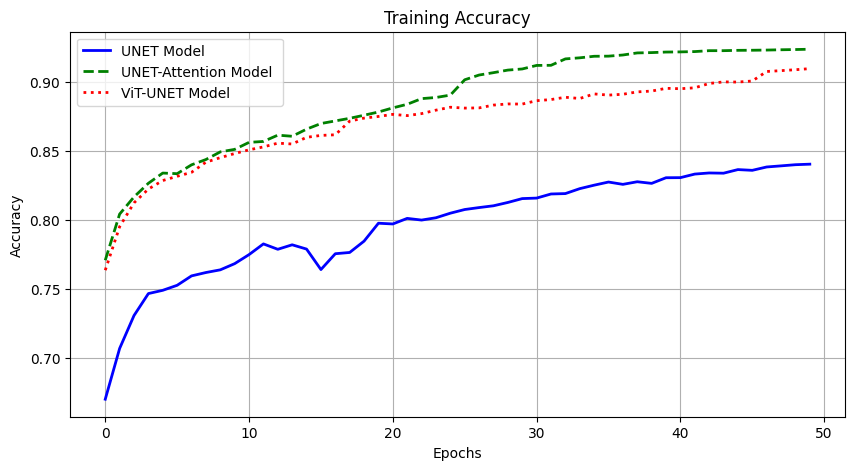

In [33]:
plt.figure(figsize=(10, 5))
for i, hist in enumerate(histories):
    plt.plot(hist['accuracy'][:50], label=model_names[i], color=colors[i], linestyle=linestyles[i], linewidth=2)
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

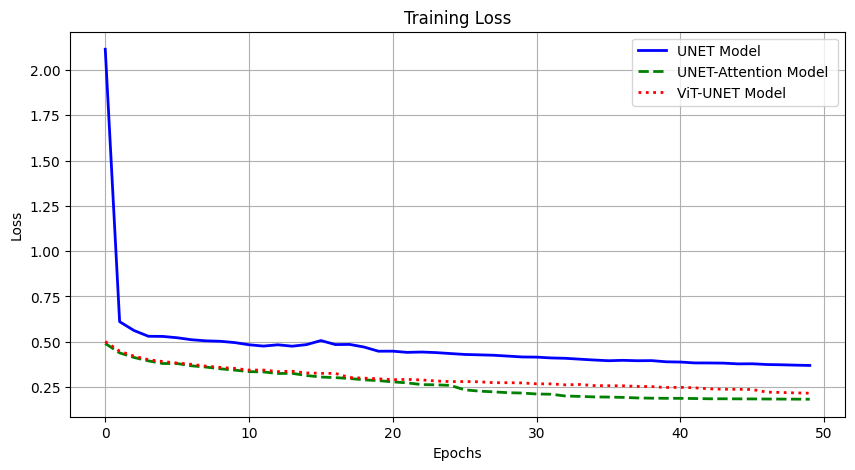

In [34]:
plt.figure(figsize=(10, 5))
for i, hist in enumerate(histories):
    plt.plot(hist['loss'][:50], label=model_names[i], color=colors[i], linestyle=linestyles[i], linewidth=2)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

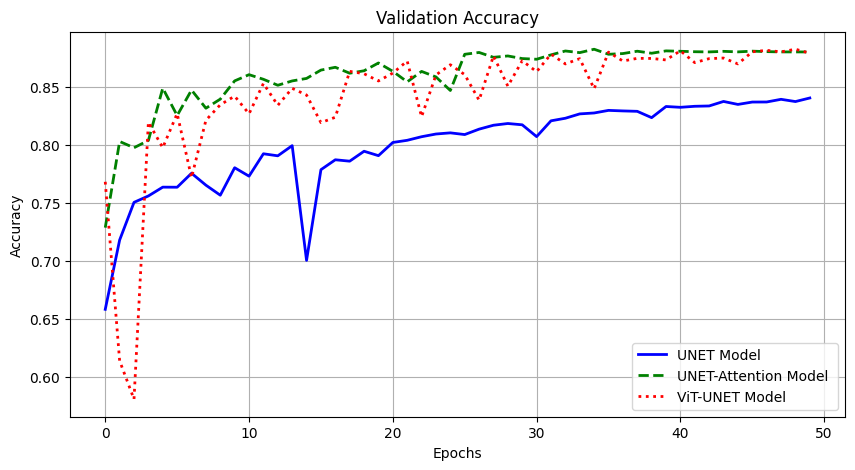

In [35]:
plt.figure(figsize=(10, 5))
for i, hist in enumerate(histories):
    plt.plot(hist['val_accuracy'][:50], label=model_names[i], color=colors[i], linestyle=linestyles[i], linewidth=2)
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

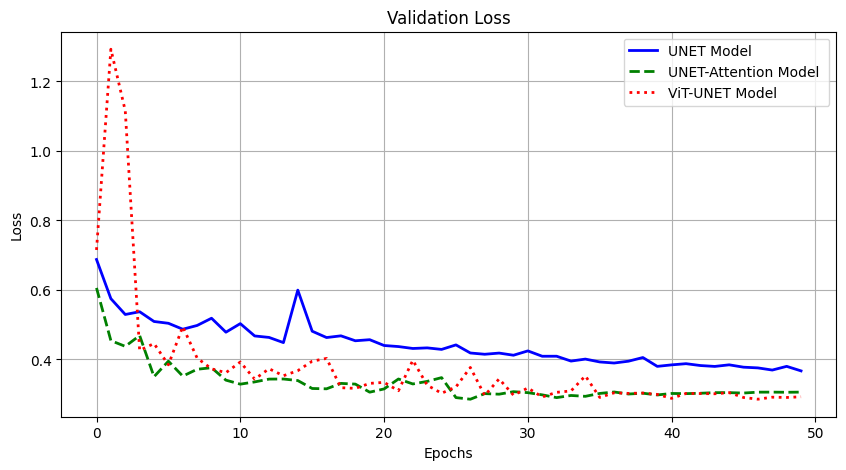

In [36]:
plt.figure(figsize=(10, 5))
for i, hist in enumerate(histories):
    plt.plot(hist['val_loss'][:50], label=model_names[i], color=colors[i], linestyle=linestyles[i], linewidth=2)
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import shutil

#working_dir = "/kaggle/working/"

for item in os.listdir(working_dir):
    item_path = os.path.join(working_dir, item)
    if os.path.isfile(item_path):  
        os.remove(item_path)  # Remove file
    elif os.path.isdir(item_path):  
        shutil.rmtree(item_path)  # Remove directory